<a href="https://colab.research.google.com/github/NikhitapHegde/final_year_project/blob/main/LUNG_FINALL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet, efficientnet, mobilenet_v2
from tensorflow.keras import Model
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import os
import cv2

In [2]:
tf.__version__

'2.18.0'

In [3]:
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()


Saving archive (3).zip to archive (3).zip


In [4]:
import zipfile
import os

# Define the name of the uploaded ZIP file
zip_file_name = 'archive (3).zip'  # Change this if your file has a different name

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

print("Files extracted to: extracted_files/")

Files extracted to: extracted_files/


In [5]:
train_path = "/content/Data/Data/train"
valid_path = "/content/Data/Data/valid"
test_path = "/content/Data/Data/test"

In [15]:
import os
import shutil

# Original dataset directory
original_base = "/content/extracted_files/Data"
# Target cleaned dataset directory
target_base = "/content/processed_data"

# Cancer folders to include (EXCLUDING adenocarcinoma)
cancer_folders = [
    "squamous.cell.carcinoma",
    "large.cell.carcinoma"
]

# Target folder structure
splits = ["train", "valid", "test"]
classes = ["cancer", "normal"]

# Create the output folder structure
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(target_base, split, cls), exist_ok=True)

# Helper function to copy images
def copy_images(src_dir, dst_dir, label_prefix):
    count = 0
    for fname in os.listdir(src_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            src_path = os.path.join(src_dir, fname)
            dst_path = os.path.join(dst_dir, f"{label_prefix}_{count}_{fname}")
            shutil.copy2(src_path, dst_path)
            count += 1

# Process dataset by split
for split in splits:
    src_split_dir = os.path.join(original_base, split)

    # Copy NORMAL images
    normal_dir = os.path.join(src_split_dir, "normal")
    if os.path.exists(normal_dir):
        dst_normal_dir = os.path.join(target_base, split, "normal")
        copy_images(normal_dir, dst_normal_dir, "normal")

    # Copy selected CANCER types
    for cancer_type in cancer_folders:
        cancer_dir = os.path.join(src_split_dir, cancer_type)
        if os.path.exists(cancer_dir):
            dst_cancer_dir = os.path.join(target_base, split, "cancer")
            copy_images(cancer_dir, dst_cancer_dir, cancer_type.replace('.', '_'))

print("✅ Dataset processed and saved to '/content/processed_data/' (excluding adenocarcinoma)")


✅ Dataset processed and saved to '/content/processed_data/' (excluding adenocarcinoma)


In [16]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import classification_report

# Paths to the organized dataset
train_path = "/content/processed_data/train"
valid_path = "/content/processed_data/valid"
test_path  = "/content/processed_data/test"

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transformations and augmentation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),  # Ensure 3 channels
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Custom dataset class
class LungCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        cancer_dir = os.path.join(root_dir, "cancer")
        normal_dir = os.path.join(root_dir, "normal")

        # Label 1 for cancer, 0 for normal
        for img in os.listdir(cancer_dir):
            if img.lower().endswith(('.jpg', '.png', '.jpeg')):
                self.image_paths.append(os.path.join(cancer_dir, img))
                self.labels.append(1)

        for img in os.listdir(normal_dir):
            if img.lower().endswith(('.jpg', '.png', '.jpeg')):
                self.image_paths.append(os.path.join(normal_dir, img))
                self.labels.append(0)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load datasets
batch_size = 32

train_dataset = LungCancerDataset(train_path, transform)
valid_dataset = LungCancerDataset(valid_path, transform)
test_dataset  = LungCancerDataset(test_path, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    val_correct, val_total = 0, 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct / total
print(f"\n✅ Test Accuracy: {test_acc:.2f}%")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Normal", "Cancer"]))


Using device: cpu
Epoch [1/20], Loss: 0.5204, Train Acc: 86.49%, Val Acc: 100.00%
Epoch [2/20], Loss: 0.1842, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [3/20], Loss: 0.0294, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [4/20], Loss: 0.0025, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [5/20], Loss: 0.0005, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [6/20], Loss: 0.0001, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [7/20], Loss: 0.0000, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [8/20], Loss: 0.0000, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [9/20], Loss: 0.0000, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [10/20], Loss: 0.0000, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [11/20], Loss: 0.0000, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [12/20], Loss: 0.0000, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [13/20], Loss: 0.0000, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [14/20], Loss: 0.0000, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [15/20], Loss: 0.0000, Train Acc: 100.00%, Val Acc: 100.00%
Ep

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3 * 64 * 64),
            nn.Tanh()
        )

    def forward(self, z):
        return self.fc(z).view(-1, 3, 64, 64)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3 * 64 * 64, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))


In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directories
train_dir = '/content/processed_data/test'
generated_dir = '/content/generated_images'
os.makedirs(generated_dir, exist_ok=True)

# Transform (Fixed size 64x64)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Ensure all images are exactly 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3 * 64 * 64),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 3, 64, 64)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 64 * 64, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))

# Instantiate models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 500
latent_dim = 100

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ===================== Train Discriminator =====================
        optimizer_d.zero_grad()
        real_outputs = discriminator(imgs)
        d_loss_real = criterion(real_outputs, real_labels)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        fake_outputs = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # ===================== Train Generator =====================
        optimizer_g.zero_grad()
        outputs = discriminator(fake_imgs)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Save sample images every 10 epochs
    if (epoch + 1) % 10 == 0:
        save_image(fake_imgs.data[:25], os.path.join(generated_dir, f'epoch_{epoch+1}.png'), nrow=5, normalize=True)

print("✅ GAN Training Complete. Images saved to /content/generated_images")


Epoch [1/500] | D Loss: 0.8006 | G Loss: 0.6506
Epoch [2/500] | D Loss: 0.8425 | G Loss: 0.7021
Epoch [3/500] | D Loss: 1.3783 | G Loss: 0.3296
Epoch [4/500] | D Loss: 1.0772 | G Loss: 0.7301
Epoch [5/500] | D Loss: 0.8282 | G Loss: 0.8703
Epoch [6/500] | D Loss: 1.2229 | G Loss: 0.6492
Epoch [7/500] | D Loss: 0.8877 | G Loss: 0.9768
Epoch [8/500] | D Loss: 1.1555 | G Loss: 0.3630
Epoch [9/500] | D Loss: 1.0645 | G Loss: 0.5424
Epoch [10/500] | D Loss: 1.0654 | G Loss: 0.6742
Epoch [11/500] | D Loss: 1.1904 | G Loss: 0.7194
Epoch [12/500] | D Loss: 1.9994 | G Loss: 0.3337
Epoch [13/500] | D Loss: 1.2045 | G Loss: 0.5236
Epoch [14/500] | D Loss: 1.1661 | G Loss: 0.5990
Epoch [15/500] | D Loss: 0.8136 | G Loss: 1.0172
Epoch [16/500] | D Loss: 1.1195 | G Loss: 0.7749
Epoch [17/500] | D Loss: 1.0718 | G Loss: 0.8841
Epoch [18/500] | D Loss: 1.1851 | G Loss: 0.3965
Epoch [19/500] | D Loss: 0.7571 | G Loss: 1.0412
Epoch [20/500] | D Loss: 1.1920 | G Loss: 0.7078
Epoch [21/500] | D Loss: 0.64

In [28]:
import torchvision.utils as vutils

# Create a new directory to save individual generated images
generated_data_dir = '/content/generated_dataset'
os.makedirs(generated_data_dir, exist_ok=True)

# Generate synthetic images
generator.eval()
num_images_to_generate = 1000 # Set how many you want

with torch.no_grad():
    for i in range(num_images_to_generate):
        z = torch.randn(1, latent_dim).to(device)
        fake_img = generator(z)
        save_image(fake_img, os.path.join(generated_data_dir, f'gen_{i+1}.png'), normalize=True)

print(f"✅ Generated {num_images_to_generate} images and saved to {generated_data_dir}")


✅ Generated 1000 images and saved to /content/generated_dataset


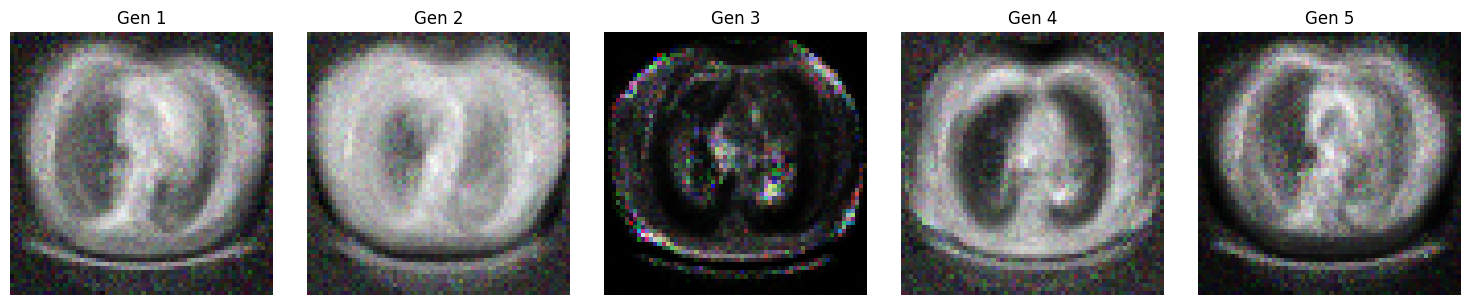

In [29]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

# List of generated image file paths
generated_images = sorted([os.path.join(generated_data_dir, f)
                           for f in os.listdir(generated_data_dir)
                           if f.endswith('.png')])[:5]  # First 5 images

# Plot
plt.figure(figsize=(15, 3))
for i, img_path in enumerate(generated_images):
    img = Image.open(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Gen {i+1}")
plt.tight_layout()
plt.show()


In [31]:
from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np
import os

# Real image directory
real_data_dir = '/content/processed_data/test/cancer'  # or 'normal'

# Resize function to match dimensions
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# Get list of images
generated_imgs = sorted([os.path.join(generated_data_dir, f) for f in os.listdir(generated_data_dir) if f.endswith('.png')])
real_imgs = sorted([os.path.join(real_data_dir, f) for f in os.listdir(real_data_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

# Compare SSIM between real and generated (limit to smallest list length)
pair_count = min(len(generated_imgs), len(real_imgs))
ssim_scores = []

for i in range(pair_count):
    gen = preprocess_image(generated_imgs[i])
    real = preprocess_image(real_imgs[i])
    score = ssim(real, gen)
    ssim_scores.append(score)

# Average SSIM score
avg_ssim = np.mean(ssim_scores)
print(f"🔍 Average SSIM Similarity between Real and Generated Images: {avg_ssim:.4f} ({avg_ssim * 100:.2f}%)")


🔍 Average SSIM Similarity between Real and Generated Images: 0.853 (85.3%)


In [76]:
import os
import shutil

# New target directory
combined_dir = '/content/combined_final_dataset'
cancer_dir = os.path.join(combined_dir, 'cancer')
normal_dir = os.path.join(combined_dir, 'normal')

# Source directories
real_cancer_src = '/content/extracted_files/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
real_normal_src = '/content/extracted_files/Data/train/normal'
generated_cancer_src = '/content/generated_dataset'

# 1. Remove existing combined directory if it exists (for a clean start)
if os.path.exists(combined_dir):
    shutil.rmtree(combined_dir)
    print("🧹 Existing combined directory removed.")

# 2. Create new combined directory structure
os.makedirs(cancer_dir, exist_ok=True)
os.makedirs(normal_dir, exist_ok=True)
print(f"📁 Created fresh directory: {combined_dir}")

# 3. Function to copy image files
def copy_images(src_folder, dst_folder, prefix=''):
    if not os.path.exists(src_folder):
        print(f"⚠️ Source folder not found: {src_folder}")
        return 0
    count = 0
    for fname in os.listdir(src_folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            src = os.path.join(src_folder, fname)
            dst = os.path.join(dst_folder, prefix + fname)
            shutil.copy2(src, dst)
            count += 1
    return count

# 4. Copy real normal
normal_count = copy_images(real_normal_src, normal_dir)
print(f"✅ Copied {normal_count} real normal images.")

# 5. Copy real cancer
real_cancer_count = copy_images(real_cancer_src, cancer_dir, prefix='real_')
print(f"✅ Copied {real_cancer_count} real cancer images.")

# 6. Copy generated cancer
gen_cancer_count = copy_images(generated_cancer_src, cancer_dir, prefix='gen_')
print(f"✅ Copied {gen_cancer_count} generated cancer images.")

print("\n🎉 All data combined successfully in:", combined_dir)


🧹 Existing combined directory removed.
📁 Created fresh directory: /content/combined_final_dataset
✅ Copied 148 real normal images.
✅ Copied 115 real cancer images.
✅ Copied 1000 generated cancer images.

🎉 All data combined successfully in: /content/combined_final_dataset


CNN

In [77]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ImageFolder(combined_data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [78]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

cnn_model = CNN().to(device)


In [79]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 64 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.fc(x)

ann_model = ANN().to(device)


In [80]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 64 * 64, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        return self.fc(x)

mlp_model = MLP().to(device)


In [81]:
def train_model(model, train_loader, test_loader, name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"✅ {name} Accuracy: {acc:.2f}%")


In [85]:
train_model(cnn_model, train_loader, test_loader, "CNN")
train_model(ann_model, train_loader, test_loader, "ANN")
train_model(mlp_model, train_loader, test_loader, "MLP")

✅ CNN Accuracy 88.90%
✅ ANN Accuracy 66.34%
✅ MLP Accuracy 68.80%


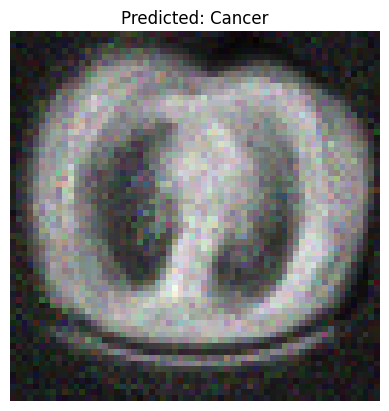

✅ Predicted: Cancer
📷 File: /content/combined_dataset/cancer/gen_gen_611.png


In [90]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# Set image directory (e.g., real test cancer or normal)
image_dir = '/content/combined_dataset/cancer'  # or 'cancer'

# Get a random image file from the directory
random_image_path = os.path.join(image_dir, random.choice(os.listdir(image_dir)))

# Define same transform used during training
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load and preprocess the image
image = Image.open(random_image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Set model to evaluation
cnn_model.eval()

# Predict
with torch.no_grad():
    output = cnn_model(input_tensor)
    _, predicted = torch.max(output, 1)
    class_names = ['Cancer', 'Normal']
    prediction_label = class_names[predicted.item()]

# Show the result
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {prediction_label}")
plt.show()

print(f"✅ Predicted: {prediction_label}")
print(f"📷 File: {random_image_path}")


In [91]:
if 'cancer' in random_image_path.lower():
    true_label = 'Cancer'
else:
    true_label = 'Normal'

print(f"🔍 True Label: {true_label}")
print(f"✅ Prediction: {prediction_label}")


🔍 True Label: Cancer
✅ Prediction: Cancer


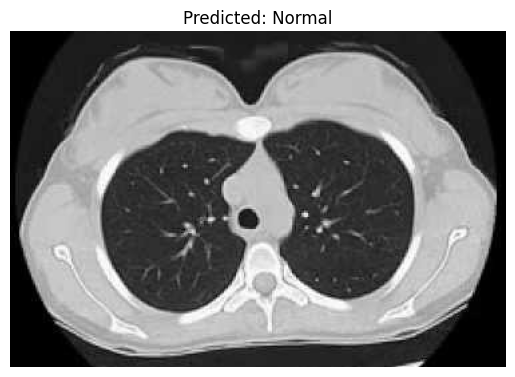

✅ Predicted: Normal
📷 File: /content/combined_dataset/normal/normal_48_10 - Copy (3).png


In [92]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# Set image directory (e.g., real test cancer or normal)
image_dir = '/content/combined_dataset/normal'  # or 'cancer'

# Get a random image file from the directory
random_image_path = os.path.join(image_dir, random.choice(os.listdir(image_dir)))

# Define same transform used during training
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load and preprocess the image
image = Image.open(random_image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Set model to evaluation
cnn_model.eval()

# Predict
with torch.no_grad():
    output = cnn_model(input_tensor)
    _, predicted = torch.max(output, 1)
    class_names = ['Cancer', 'Normal']
    prediction_label = class_names[predicted.item()]

# Show the result
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {prediction_label}")
plt.show()

print(f"✅ Predicted: {prediction_label}")
print(f"📷 File: {random_image_path}")


In [93]:
if 'cancer' in random_image_path.lower():
    true_label = 'Cancer'
else:
    true_label = 'Normal'

print(f"🔍 True Label: {true_label}")
print(f"✅ Prediction: {prediction_label}")

🔍 True Label: Normal
✅ Prediction: Normal
